In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Import libraries

In [4]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk

sns.set()

# Patient Selection

In [5]:
df_start = pd.read_csv('./data/patient_data.csv')
df_start = df_start.drop('PatientName', axis=1)
df_start.head()

,PatientID,PatientBirthDate,PatientAge,PatientSex,PatientSize,PatientWeight,StudyDate,Manufacturer,StationName,StudyDescription,MagneticFieldStrength,StudyInstanceUID
0,9571,1978-07-26,41,M,NaN,70,2019-08-20,SIEMENS,MRC40242,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20190820150305.2341468.1
1,46185,1965-08-28,53,F,NaN,95,2019-07-18,SIEMENS,MRC40242,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20190718113015.2326596.1
2,64413,1965-06-24,52,M,NaN,83,2018-02-13,SIEMENS,MRC40242,RM ADDOME SUPERIORE SENZA E CON CONTRASTO,3.0,1.3.76.13.63891.2.20180213113226.1949796.1
3,83715,1948-10-15,73,M,NaN,65,2022-03-16,Philips Medical Systems,PHILIPS-SSHOU69,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,1.5,1.3.76.13.63891.2.20220316112058.3467593.1
4,93500,1963-03-16,56,M,NaN,90,2019-10-26,SIEMENS,MRC40242,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20191026075826.2390704.1


In [6]:
# number of patients in the initial dataset
initial_n_patients = len(df_start['PatientID'].unique())
initial_n_patients

124

In [7]:
# check min and max date
print(df_start['StudyDate'].max())
print(df_start['StudyDate'].min())

2022-03-21
2013-01-10


In [8]:
# exclusion criteria 1

# magnetic field needs to be 3 Tesla
df_included = df_start[df_start['MagneticFieldStrength']==3]
current_patients = len(df_included['PatientID'].unique())

# number of patients excluded with this criteria
tesla_excluded = initial_n_patients - current_patients
tesla_excluded

33

In [9]:
# exclusion criteria 2 

# need images in all 3 main planes
# this patient doesn't have the axial image
df_included = df_included[df_included.PatientID != 1492496]


current_patients = len(df_included['PatientID'].unique())
current_patients

90

In [10]:
# exclusion criteria 3

# need labels for the images
# check from the data folder which patients have labels

labelled_axial_dataset = '../01_dataset_creation/nnUNet_Raw/Dataset001_axial/imagesTr'
labelled_coronal_dataset = '../01_dataset_creation/nnUNet_Raw/Dataset002_coronal/imagesTr'
labelled_sagittal_dataset = '../01_dataset_creation/nnUNet_Raw/Dataset003_sagittal/imagesTr'

labelled_axial_ids = [int(x.split('_')[0]) for x in os.listdir(labelled_axial_dataset)]
labelled_coronal_ids = [int(x.split('_')[0]) for x in os.listdir(labelled_coronal_dataset)]
labelled_sagittal_ids = [int(x.split('_')[0]) for x in os.listdir(labelled_sagittal_dataset)]

labelled_ids = list(set(labelled_axial_ids + labelled_coronal_ids + labelled_sagittal_ids))

df_end = df_included[df_included.PatientID.isin(labelled_ids)]
patient_ids = df_end['PatientID'].unique()

final_n_patients = len(patient_ids)
final_n_patients

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../01_dataset_creation/nnUNet_Raw/Dataset001_axial/imagesTr'

In [ ]:
# some patients have mulitple series, but only one was labelled
# for demographical data we dont care

df_end = df_end.drop_duplicates('PatientID')
df_end.shape

(60, 13)

In [ ]:
df_end['PatientSex'].value_counts()

PatientSex
M     34
F     25
F      1
Name: count, dtype: int64

In [ ]:
df_end['PatientAge'].describe()

count    60.000000
mean     42.633333
std      14.358564
min      19.000000
25%      30.750000
50%      41.000000
75%      52.250000
max      80.000000
Name: PatientAge, dtype: float64

# MRI informations

In [ ]:
df_mri = pd.read_csv('./data/df_current.csv', index_col=0)
df_mri.head()

,json,ID,Study,View,Serie,path,max_z,Spacing_x/y,Spacing_z,Size_x,...,InPlanePhaseEncodingDirectionDICOM,ConversionSoftware,ConversionSoftwareVersion,BodyPartExamined,Interpolation2D,ReceiveCoilActiveElements,ConsistencyInfo,PhaseOversampling,RawImage,in_current_dataset
3,9571_t2_haste_TRA_bh_4MMa.json,9571,20190820-RMN ADDOME SUPERIORE CON E SENZA CONT...,axial,t2_haste_TRA_bh_4MMa,/home/mattia/Desktop/tesi_crohn/Data/nifti_fil...,21.099669,1.172,4.4,384,...,COL,dcm2niix,v1.0.20220505,NaN,NaN,NaN,NaN,NaN,NaN,1
8,"64413_t2_haste_TRA_bh_4MM_ct_BO1,2_SP1-3.json",64413,20180213-RM ADDOME SUPERIORE SENZA E CON CONTR...,axial,"t2_haste_TRA_bh_4MM_ct_BO1,2_SP1-3",/home/mattia/Desktop/tesi_crohn/Data/nifti_fil...,264.481750,1.312,4.4,320,...,COL,dcm2niix,v1.0.20211006,NaN,NaN,NaN,NaN,NaN,NaN,1
13,92197_t2_haste_TRA_bh_4MM.json,92197,20190215-RMN ADDOME SUPERIORE CON E SENZA CONT...,axial,t2_haste_TRA_bh_4MM,/home/mattia/Desktop/tesi_crohn/Data/nifti_fil...,36.603975,1.172,4.4,384,...,COL,dcm2niix,v1.0.20211006,NaN,NaN,NaN,NaN,NaN,NaN,1
22,94628_t2_haste_tra_p2_mbh_448.json,94628,20211022-RMN ADDOME INFERIORE CON E SENZA CONT...,axial,t2_haste_tra_p2_mbh_448,/home/mattia/Desktop/tesi_crohn/Data/nifti_fil...,311.708586,0.848,4.8,448,...,COL,dcm2niix,v1.0.20211006,ABDOMEN,NaN,"BO1;BO2,3;SP2-4",N4_VE11E_LATEST_20181129,NaN,NaN,1
39,284282_t2_haste_TRA_bh_4MMa.json,284282,20201013-RMN ADDOME SUPERIORE CON E SENZA CONT...,axial,t2_haste_TRA_bh_4MMa,/home/mattia/Desktop/tesi_crohn/Data/nifti_fil...,3.254198,1.172,4.4,384,...,COL,dcm2niix,v1.0.20211006,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# number of images in each dataset
df_mri.value_counts('View')

View
sagittal    60
axial       59
coronal     59
Name: count, dtype: int64

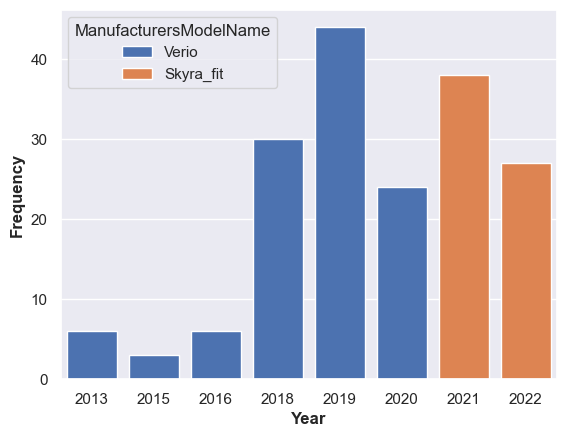

In [ ]:
# images each year
df_mri['date'] = df_mri['Study'].apply(lambda x: x[:8])
df_mri['date'] = pd.to_datetime(df_mri['date'], format='%Y%m%d')

sns.countplot(x=df_mri.date.dt.year, hue=df_mri.ManufacturersModelName, palette='deep', alpha=1, saturation=1)
plt.ylabel('Frequency',  weight='bold')
plt.xlabel('Year',  weight='bold')
plt.savefig('./images/images_per_mri.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# unique number of image acquisition protocols
df_mri.groupby(['View','ManufacturersModelName'])[['SequenceName']].nunique()

SequenceName
View     ManufacturersModelName              
axial    Skyra_fit                          1
         Verio                              6
coronal  Skyra_fit                          1
         Verio                              5
sagittal Skyra_fit                          1
         Verio                             12

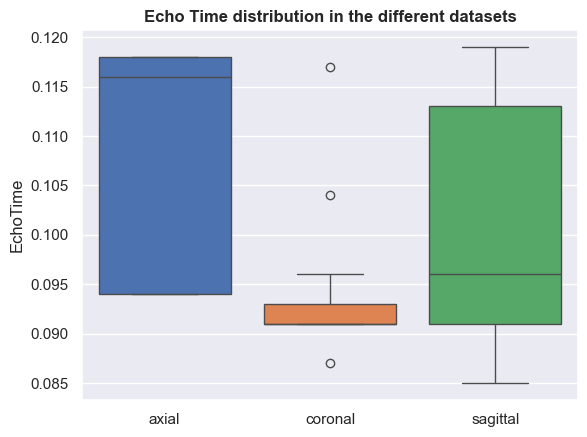

In [ ]:
ax = sns.boxplot(data=df_mri, y='EchoTime', x='View', hue='View', saturation=1)
ax.set(xlabel=None)
plt.title('Echo Time distribution in the different datasets', weight='bold')
plt.savefig('./images/Echotime.pdf',bbox_inches='tight', pad_inches=0)

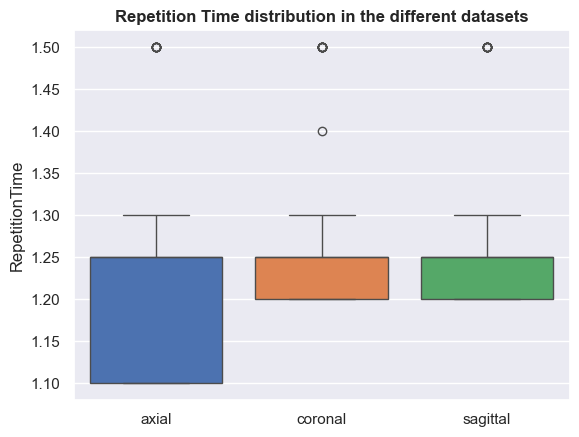

In [ ]:
ax = sns.boxplot(data=df_mri, y='RepetitionTime', x='View', hue='View', saturation=1)
ax.set(xlabel=None)

plt.title('Repetition Time distribution in the different datasets', weight='bold')
plt.savefig('./images/Repetitiontime.pdf',bbox_inches='tight', pad_inches=0)

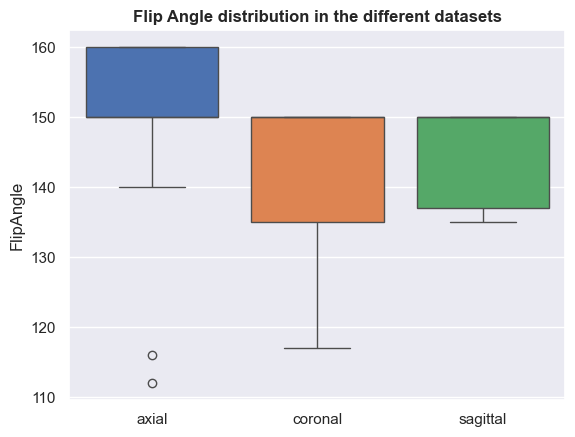

In [ ]:
ax = sns.boxplot(data=df_mri, y='FlipAngle', x='View', hue='View', saturation=1)
ax.set(xlabel=None)

plt.title('Flip Angle distribution in the different datasets', weight='bold')
plt.savefig('./images/FlipAngle.pdf',bbox_inches='tight', pad_inches=0)

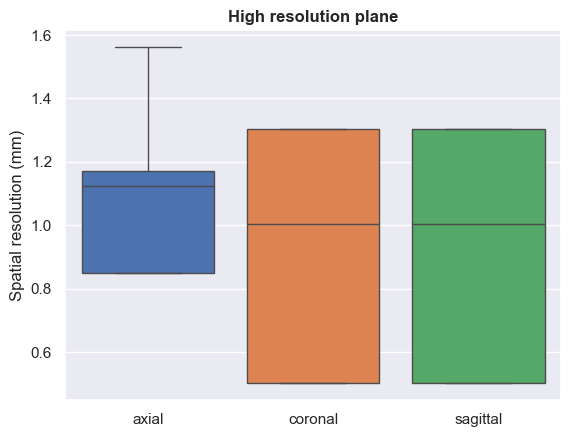

In [ ]:
ax = sns.boxplot(data=df_mri, y='Spacing_x/y', x='View', hue='View', saturation=1)
ax.set(xlabel=None)

plt.ylabel('Spatial resolution (mm)')
plt.title('High resolution plane', weight='bold')

plt.savefig('./images/hig_res_plane.pdf',bbox_inches='tight', pad_inches=0)

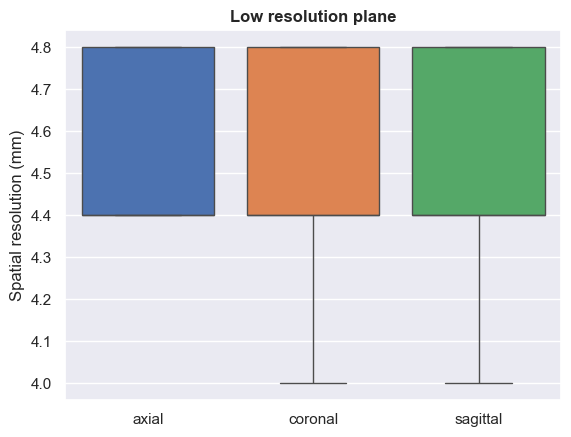

In [ ]:
ax = sns.boxplot(data=df_mri, y='Spacing_z', x='View', hue='View', saturation=1)
ax.set(xlabel=None)

plt.ylabel('Spatial resolution (mm)')
plt.title('Low resolution plane', weight='bold')
plt.savefig('./images/low_res_plane.pdf',bbox_inches='tight', pad_inches=0)

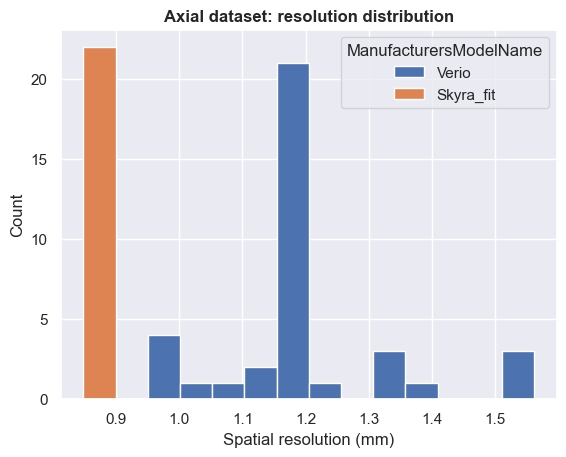

In [ ]:
sns.histplot(data=df_mri[df_mri.View=='axial'], x='Spacing_x/y', binwidth=0.05, hue = 'ManufacturersModelName', palette='deep', alpha=1)
plt.xlabel('Spatial resolution (mm)')
plt.title('Axial dataset: resolution distribution', weight='bold')
plt.savefig('./images/axial_res.pdf',bbox_inches='tight', pad_inches=0)

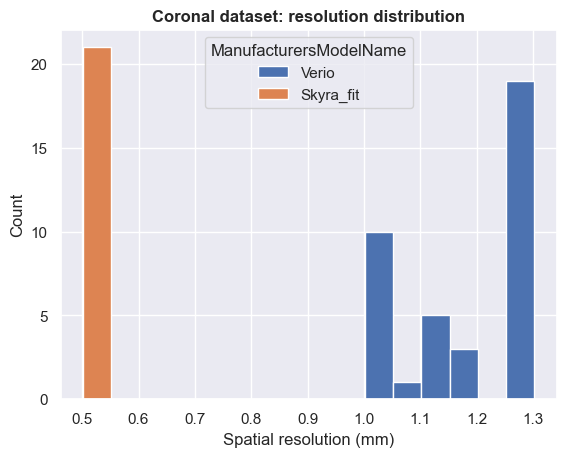

In [ ]:
sns.histplot(data=df_mri[df_mri.View=='coronal'], x='Spacing_x/y', binwidth=0.05, hue = 'ManufacturersModelName', palette='deep', alpha=1)
plt.xlabel('Spatial resolution (mm)')
plt.title('Coronal dataset: resolution distribution', weight='bold')
plt.yticks([0, 5, 10, 15, 20])
plt.savefig('./images/coronal_res.pdf',bbox_inches='tight', pad_inches=0)

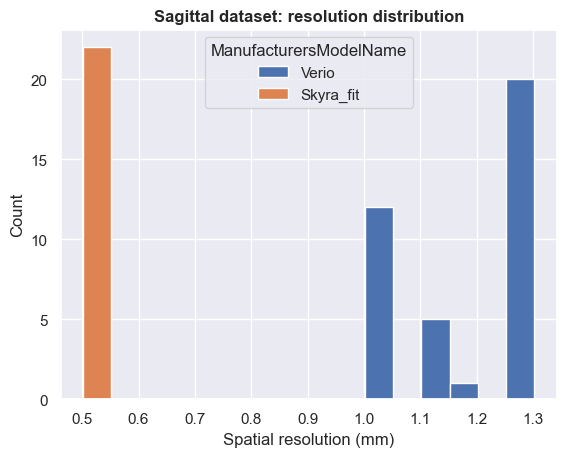

In [ ]:
sns.histplot(data=df_mri[df_mri.View=='sagittal'], x='Spacing_x/y', binwidth=0.05, hue = 'ManufacturersModelName', palette='deep', alpha=1)
plt.xlabel('Spatial resolution (mm)')
plt.yticks([0, 5, 10, 15, 20])
plt.title('Sagittal dataset: resolution distribution', weight='bold')
plt.savefig('./images/sagittal_res.pdf',bbox_inches='tight', pad_inches=0)

In [ ]:
df_mri[df_mri.View=='axial']['upper_lower'].value_counts()

upper_lower
lower    40
upper    19
Name: count, dtype: int64

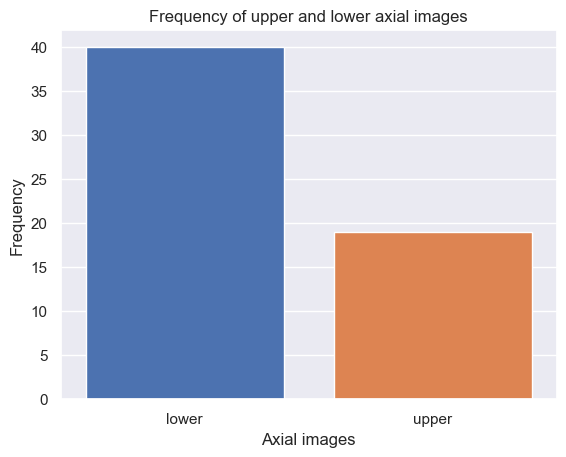

In [ ]:
sns.countplot(data=df_mri[df_mri.View=='axial'], x='upper_lower', hue='upper_lower', alpha=1, saturation=1)
plt.ylabel('Frequency')
plt.title('Frequency of upper and lower axial images')
plt.xlabel('Axial images')
plt.savefig('./images/upper_lower.pdf', bbox_inches='tight', pad_inches=0)

# Labels

In [ ]:
# need to create a dataset with label size information

folder_ax  = '../01_dataset_creation/nnUNet_Raw/Dataset001_axial/labelsTr/'
folder_cor = '../01_dataset_creation/nnUNet_Raw/Dataset002_coronal/labelsTr/'
folder_sag = '../01_dataset_creation/nnUNet_Raw/Dataset003_sagittal/labelsTr/'


folder = []
mask = []
rel_vol = []

def parse(f, view):
    
    for patient_id in os.listdir(f):
        label = sitk.ReadImage(os.path.join(f, patient_id))
        label = sitk.GetArrayFromImage(label)

        rel_volume = label.sum()/label.size

        folder.append(view)
        mask.append(patient_id)
        rel_vol.append(rel_volume)
    
    print(f'Finished parsing folder {view}')
    

parse(folder_ax, 'axial')
parse(folder_cor, 'coronal')
parse(folder_sag, 'sagittal')

df_labels = pd.DataFrame({'View': folder, 'ID': mask, 'rel_vol':rel_vol})
df_labels

Finished parsing folder axial
Finished parsing folder coronal
Finished parsing folder sagittal


,View,ID,rel_vol
0,axial,1513290.nii,0.000063
1,axial,5291583.nii,0.001361
2,axial,5283984.nii,0.000307
3,axial,390232.nii,0.000506
4,axial,1737960.nii,0.001609
...,...,...,...
173,sagittal,1767036.nii,0.000025
174,sagittal,1469367.nii,0.000086
175,sagittal,5146467.nii,0.000391
176,sagittal,1475647.nii,0.000050


In [ ]:
df_labels['%'] = df_labels.rel_vol * 100

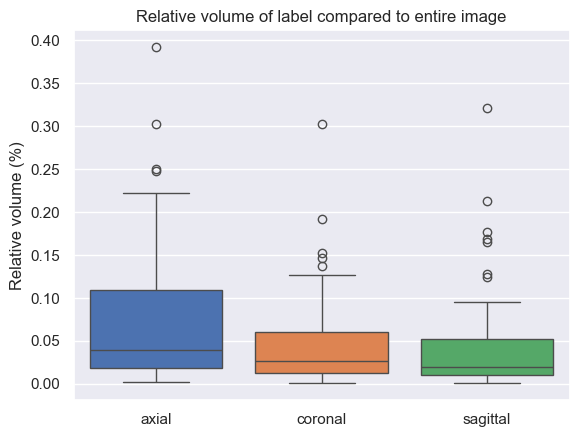

In [ ]:
ax = sns.boxplot(data=df_labels, y='%', x='View', hue='View', saturation=1)
ax.set(xlabel=None)

plt.title('Relative volume of label compared to entire image')
plt.ylabel('Relative volume (%)')
plt.savefig('./images/relative_volume.pdf',bbox_inches='tight', pad_inches=0)

# Clinical data

In [11]:
df_clinical = pd.read_csv('./data/clinical_data.csv')
df_clinical = df_clinical[df_clinical.PatientID.isin(patient_ids)]
df_clinical = df_clinical[df_clinical.MagneticFieldStrength == 3]
df_clinical

NameError: name 'patient_ids' is not defined

In [13]:
df_clinical[df_clinical.duplicated('PatientID', keep=False)].drop('PatientName', axis=1)

,PatientID,PatientBirthDate,PatientAge,PatientSex,PatientSize,PatientWeight,StudyDate,Manufacturer,StationName,StudyDescription,MagneticFieldStrength,StudyInstanceUID,Data Colon,Reperti Colon,Rutgeerts,SES CD,PCR,PCR data,Calc,Calc data
11,284282,25/01/1967,53,F,NaN,88,13/10/2020,SIEMENS,MRC40242,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20201013113330.2616087.1,20/07/2020,NaN,NaN,0.0,1.37,31/10/2020,312.0,31/10/2020
12,284282,25/01/1967,54,F,1.76,100,21/01/2022,SIEMENS,MRC40242,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20220121124239.3415931.1,07/03/2022,NaN,NaN,2.0,0.50,01/02/2022,317.0,01/02/2022
22,928807,21/04/1970,48,F,NaN,80,04/12/2018,SIEMENS,MRC40242,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20181204130025.2158695.1,27/09/2018,NaN,NaN,10.0,1.00,19/09/2018,104.0,19/09/2018
23,928807,21/04/1970,51,F,1.65,72,14/03/2022,SIEMENS,MRC40242,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20220314115613.3464988.1,17/05/2021,NaN,i4,NaN,0.80,25/05/2022,382.0,25/05/2022
44,1683726,05/03/1994,24,M,NaN,68,05/11/2018,SIEMENS,MRC40242,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20181105130933.2135210.1,08/11/2018,NaN,i2,NaN,0.22,20/12/2018,NaN,NaN
45,1683726,05/03/1994,24,M,NaN,60,06/11/2018,SIEMENS,MRC40242,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20181106121521.2136217.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,1978998,22/11/1991,29,M,1.75,70,31/08/2021,SIEMENS,MRC40242,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20210831152746.2858080.1,14/07/2021,NaN,NaN,16.0,11.80,16/03/2021,859.0,16/03/2021
68,1978998,22/11/1991,29,M,1.75,70,31/08/2021,SIEMENS,NaN,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20210831152746.2858081.1,14/07/2021,NaN,NaN,16.0,11.80,16/03/2021,859.0,16/03/2021
69,1980187,10/11/1966,54,F,NaN,71,07/06/2021,Philips Medical Systems,PHILIPS-SSHOU69,RMN ADDOME INFERIORE CON E SENZA CONTRASTO,1.5,1.3.76.13.63891.2.20210607095545.2800449.1,06/08/2021,NaN,NaN,3.0,NaN,NaN,NaN,NaN
70,1980187,10/11/1966,55,F,1.78,67,09/03/2022,SIEMENS,MRC40242,RMN ADDOME SUPERIORE CON E SENZA CONTRASTO,3.0,1.3.76.13.63891.2.20220309115751.3460792.1,06/08/2021,NaN,NaN,3.0,NaN,NaN,NaN,NaN


In [ ]:
idx_to_drop = [68, 45, 102, 103, 12]
df_clinical = df_clinical.drop(idx_to_drop)

In [ ]:
df_clinical.to_csv('../03_results_analysis/clinical_results.csv')

In [ ]:
df_clinical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 133
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientID              60 non-null     int64  
 1   PatientName            60 non-null     object 
 2   PatientBirthDate       60 non-null     object 
 3   PatientAge             60 non-null     int64  
 4   PatientSex             60 non-null     object 
 5   PatientSize            23 non-null     float64
 6   PatientWeight          60 non-null     int64  
 7   StudyDate              60 non-null     object 
 8   Manufacturer           60 non-null     object 
 9   StationName            60 non-null     object 
 10  StudyDescription       60 non-null     object 
 11  MagneticFieldStrength  60 non-null     float64
 12  StudyInstanceUID       60 non-null     object 
 13  Data Colon             45 non-null     object 
 14  Reperti Colon          1 non-null      object 
 15  Rutgeerts   

## Rutgeerts

In [ ]:
df_clinical['Rutgeerts'].value_counts()

Rutgeerts
i4    12
i2     4
i1     4
i0     1
Name: count, dtype: int64

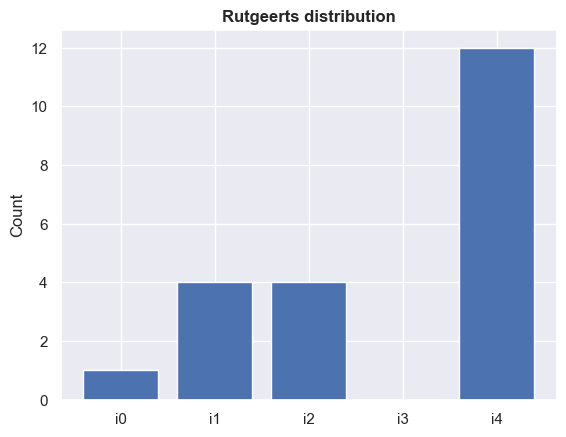

In [ ]:
plt.bar(['i0', 'i1', 'i2', 'i3', 'i4'], [1, 4, 4, 0, 12])
plt.title('Rutgeerts distribution', weight = 'bold')
plt.ylabel('Count')
plt.savefig('./images/Rutgeerts.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df_clinical['StudyDate'] = pd.to_datetime(df_clinical['StudyDate'], format="%d/%m/%Y")
df_clinical['Data Colon'] = pd.to_datetime(df_clinical['Data Colon'], format="%d/%m/%Y")
df_clinical['PCR data'] = pd.to_datetime(df_clinical['PCR data'], format="%d/%m/%Y")
df_clinical['Calc data'] = pd.to_datetime(df_clinical['Calc data'], format="%d/%m/%Y")

In [ ]:
df_clinical['delta_colon'] = round((df_clinical['Data Colon'] - df_clinical['StudyDate']) / np.timedelta64(1, 'W'))
df_clinical['delta_pcr'] = round((df_clinical['PCR data'] - df_clinical['StudyDate']) / np.timedelta64(1, 'W'))
df_clinical['delta_calc'] = round((df_clinical['Calc data'] - df_clinical['StudyDate']) / np.timedelta64(1, 'W'))

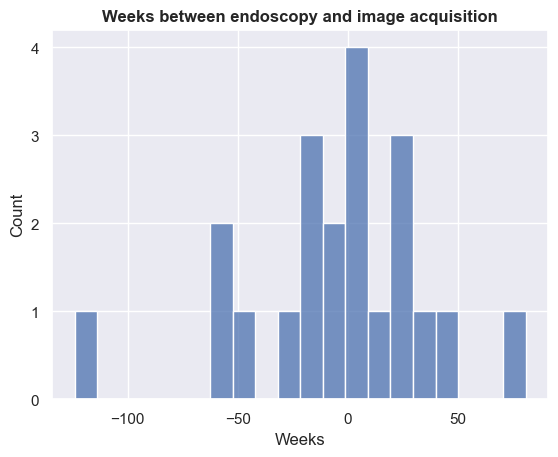

In [ ]:
sns.histplot(df_clinical.dropna(subset='Rutgeerts')['delta_colon'], binwidth=10)
plt.title('Weeks between endoscopy and image acquisition', weight = 'bold')
plt.xlabel('Weeks')
plt.yticks([0,1,2,3,4])
plt.savefig('./images/Rutgeerts_weeks.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df_clinical['Rutgeerts'].describe()

count     21
unique     4
top       i4
freq      12
Name: Rutgeerts, dtype: object

In [ ]:
abs(df_clinical.dropna(subset='Rutgeerts')['delta_colon']).describe()

count     21.000000
mean      29.095238
std       30.959497
min        0.000000
25%        4.000000
50%       24.000000
75%       43.000000
max      124.000000
Name: delta_colon, dtype: float64

## SES CD

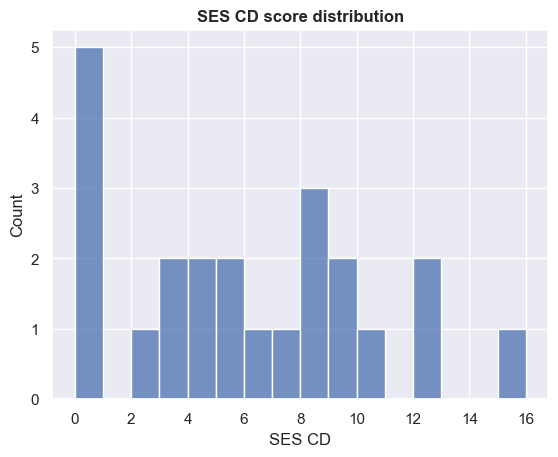

In [ ]:
sns.histplot(df_clinical['SES CD'], binwidth=1)
plt.title('SES CD score distribution', weight = 'bold')
plt.savefig('./images/SES_CD.pdf', bbox_inches='tight', pad_inches=0)

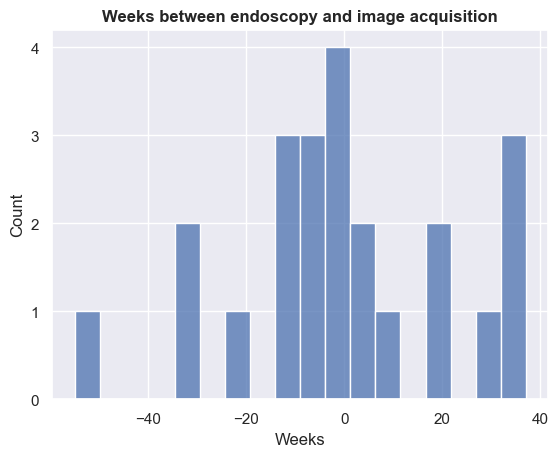

In [ ]:
sns.histplot(df_clinical.dropna(subset='SES CD')['delta_colon'], binwidth=5)
plt.title('Weeks between endoscopy and image acquisition', weight = 'bold')
plt.xlabel('Weeks')
plt.yticks([0,1,2,3,4])
plt.savefig('./images/SES_CD_weeks.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df_clinical['SES CD'].describe()

count    23.000000
mean      5.695652
std       4.476553
min       0.000000
25%       2.500000
50%       5.000000
75%       8.500000
max      16.000000
Name: SES CD, dtype: float64

In [ ]:
abs(df_clinical.dropna(subset='SES CD')['delta_colon']).describe()

count    23.000000
mean     16.782609
std      15.279090
min       0.000000
25%       4.500000
50%      11.000000
75%      30.500000
max      55.000000
Name: delta_colon, dtype: float64

## PCR 

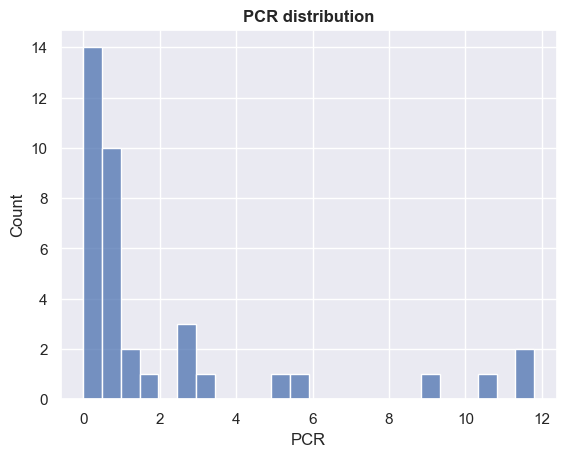

In [ ]:
sns.histplot(df_clinical['PCR'], binwidth=0.5)
plt.title('PCR distribution', weight = 'bold')
plt.savefig('./images/PCR.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
(df_clinical['PCR'].dropna()< 1).sum()

24

In [ ]:
24/37

0.6486486486486487

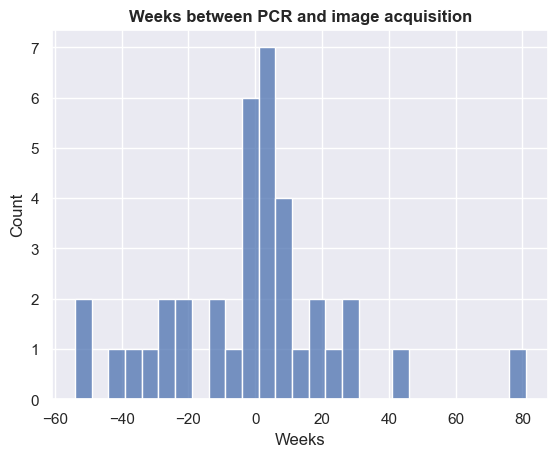

In [ ]:
sns.histplot(df_clinical.dropna(subset='PCR')['delta_pcr'], binwidth=5)
plt.title('Weeks between PCR and image acquisition', weight = 'bold')
plt.xlabel('Weeks')
#plt.yticks([0,1,2,3,4])
plt.savefig('./images/PCR_weeks.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
abs(df_clinical.dropna(subset='PCR')['delta_pcr']).describe()

count    37.000000
mean     18.162162
std      18.654034
min       0.000000
25%       3.000000
50%      11.000000
75%      28.000000
max      81.000000
Name: delta_pcr, dtype: float64

## Calc

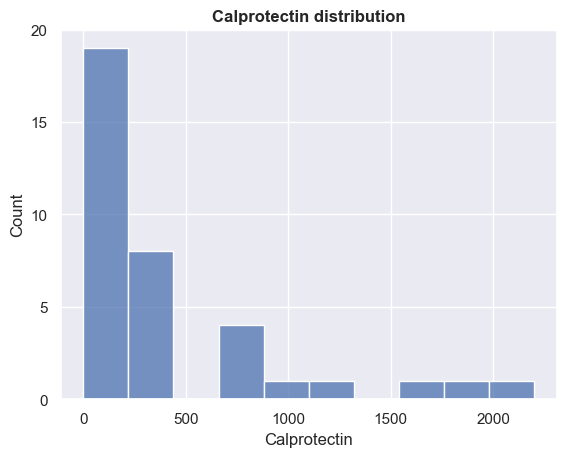

In [ ]:
sns.histplot(df_clinical['Calc'])
plt.title('Calprotectin distribution', weight = 'bold')
plt.yticks([0,5,10,15,20])
plt.xlabel('Calprotectin')
plt.savefig('./images/calc.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df_clinical['Calc'].dropna().round(-2).value_counts()

Calc
100.0     9
0.0       7
300.0     6
200.0     4
800.0     2
400.0     1
1700.0    1
1100.0    1
900.0     1
1800.0    1
1300.0    1
2200.0    1
700.0     1
Name: count, dtype: int64

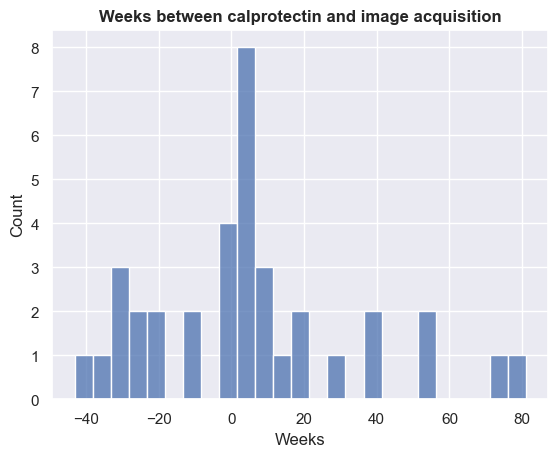

In [ ]:
sns.histplot(df_clinical.dropna(subset='Calc')['delta_calc'], binwidth=5)
plt.title('Weeks between calprotectin and image acquisition', weight = 'bold')
plt.xlabel('Weeks')
#plt.yticks([0,1,2,3,4])
plt.savefig('./images/calc_weeks.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
abs(df_clinical.dropna(subset='Calc')['delta_calc']).describe()

count    36.000000
mean     21.444444
std      20.993121
min       0.000000
25%       4.500000
50%      16.000000
75%      33.000000
max      81.000000
Name: delta_calc, dtype: float64